# Space: How Important is it in the NBA

Using kaggle Data on shots taken (insert link here) during the 2014-2015 season, we will determine the effect of space by answering these four questions: 
1. Which players create space well on offense?
2. What effect does space have on an player's shooting percentage?(offense's perspective)
3. Which defenders are best at staying with their targets?
4. Does that distance from an offensive player influence shooting percentage?

In [1]:
#import packages for processing data: numpy, pandas, matplotlib.pyplot, and seasborn
from shotLog_functions import *
from sequential_forward_selection import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
# visualize 3 dimensions 
from mpl_toolkits import mplot3d 
from sklearn.linear_model import LinearRegression # might use this for linear fit
import seaborn as sns

ploton = False
    
#load dataset
shot_logs = pd.read_csv(r"../Data/basketball/shot_logs.csv")

The dataset comprises 128069 rows and 21 columns. The dataset is clean and includes information such as who took the shot, which shot it was (1st, 2nd, etc.), how far from the basket the shot was taken, who was the closest defender, how far away was the nearest defender, time on the shot clock, and much more. The data was scraped from the NBA's REST API. According to the NBA Advanced Statistics page, to qualify for NBA league leader in field goal percentage a player is required to have made at least 300 field goals in the season being evaluated. Implementing this criteria, reduces the list of players we need to consider to only 59 players.

## Offense

In [2]:
## create a copy of the data and delete columns we don't plan on using. 
X = shot_logs.copy()
X = X.drop(columns=['MATCHUP','LOCATION','W','FINAL_MARGIN','PERIOD','GAME_CLOCK',
                    'GAME_ID','SHOT_NUMBER', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME'])

#GET PLAYERS WHO HAD MORE THAN 300 MADE BASKETS
shots_made = X.loc[X['SHOT_RESULT']=='made'] #get only rows with a made shot
shots_made = shots_made.groupby('player_name')['SHOT_RESULT'].agg(SHOTS_MADE='count') #get total makes for each player
shots_made = shots_made.loc[shots_made.SHOTS_MADE >= 300] #keep rows where there were over 300 makes

#names of valid players as list
valid_players = shots_made.index 
#show head of dataframe
print(valid_players.tolist())

['al horford', 'al jefferson', 'andre drummond', 'andrew wiggins', 'anthony davis', 'avery bradley', 'blake griffin', 'brandon knight', 'brook lopez', 'carlos boozer', 'carmelo anthony', 'chandler parsons', 'chris bosh', 'chris paul', 'damian lillard', 'demarcus cousins', 'derrick favors', 'derrick rose', 'dirk nowitzki', 'dwayne wade', 'enes kanter', 'eric bledsoe', 'goran dragic', 'gordon hayward', 'greg monroe', 'jamal crawford', 'james harden', 'jeff green', 'jeff teague', 'jimmy butler', 'joe johnson', 'john wall', 'kevin love', 'klay thompson', 'kyle lowry', 'kyrie irving', 'lamarcus aldridge', 'lebron james', 'marc gasol', 'marcin gortat', 'markieff morris', 'mike conley', 'monta ellis', 'nikola vucevic', 'pau gasol', 'paul millsap', 'rudy gay', 'russell westbrook', 'serge ibaka', 'stephen curry', 'thaddeus young', 'tim duncan', 'tobias harris', 'ty lawson', 'tyreke evans', 'victor oladipo', 'wesley matthews', 'wilson chandler', 'zach randolph']


In [3]:
X.PTS_TYPE.value_counts()

2    94173
3    33896
Name: PTS_TYPE, dtype: int64

Using the effective field goal percentage as our metric, we can scale the data and sort it to evaluate a player's performance with respect to their peers. Effective field goal percentage is defined as: $$\frac{\text{2PtFG} + 1.5 \cdot \text{3PtFG}}{\text{FGA}} $$ where $\text{2PtFG}$ represents the number of made 2-pointers, $\text{3PtFG}$ represents the number of made 3-pointers, and $\text{FGA}$ represents the number of shot attempts.

In [4]:
## CALCULATE EFG, Avg Shot Distance and Avg Closest Defender Distance (Avg Space)
# get FG% these are 2s and threes
FG = X.groupby('player_name').FGM.agg(FG ='mean')
# get 3P% or FGA
EFG = X.groupby('player_name')['PTS'].agg(EFG = lambda x: np.mean(x==3))
# EFG% = FGM/FGA + 0.5 *3PM/FGA 
EFG.EFG = 0.5*EFG.EFG+FG.FG

# Get average defender distance and join to EFG df
Avg_Dist = X.groupby('player_name').CLOSE_DEF_DIST.agg(Avg_Dist='mean')
EFG = EFG.join(Avg_Dist)

# get shot distance and join to EFG df
Shot_Dist = X.groupby('player_name').SHOT_DIST.agg(Avg_Shot = 'mean')
EFG = EFG.join(Shot_Dist)

# filter using valid players list
EFG = EFG.loc[valid_players]
# scale data by taking z-scores
studentized_EFG = (EFG-EFG.mean())/EFG.std()
studentized_EFG = studentized_EFG.sort_values(by='Avg_Dist',ascending=False)
# show players that got the most space on offense
studentized_EFG.head()


,EFG,Avg_Dist,Avg_Shot
player_name,,,
serge ibaka,0.685736,1.807268,0.800344
al horford,1.562218,1.718831,-0.252155
wesley matthews,2.165794,1.689822,1.771038
blake griffin,0.077877,1.230468,-0.298132
chris paul,1.124938,1.210840,1.182275


In [5]:
# show players that got the least space on offense
studentized_EFG = studentized_EFG.sort_values(by='Avg_Dist',ascending=True)
studentized_EFG.head()

,EFG,Avg_Dist,Avg_Shot
player_name,,,
greg monroe,-0.392290,-2.827480,-2.397694
andre drummond,0.190704,-2.445420,-2.591724
zach randolph,-0.358234,-1.795212,-1.425869
al jefferson,-0.840004,-1.653747,-1.073401
tim duncan,-0.209436,-1.588930,-1.445737


The previous tables show the players who, on average, got the most and least space, respectively. The players who created the least space were all "big men". 

In [6]:
## Ended up settling on a 2nd degree polynomial because the adj R2 was better
## than the adj R2 of the 3rd degree model. And for the 3rd degree model, only the 
## second order term has a confidence interval excluding 0. 
## Tried using height as a predictor but it wasn't very helpful

lm2 = polyFit(studentized_EFG.Avg_Dist.values.reshape(-1,1), \
              studentized_EFG.EFG.values.reshape(-1,1), 2)
print(lm2.summary())
x0, x1, x2 = lm2.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     4.996
Date:                Mon, 01 Aug 2022   Prob (F-statistic):             0.0101
Time:                        10:01:45   Log-Likelihood:                -78.370
No. Observations:                  59   AIC:                             162.7
Df Residuals:                      56   BIC:                             169.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1952      0.152     -1.288      0.2

In [7]:
#Using forward search yields a model that uses defender distance and shot distance
predictors = studentized_EFG.columns.tolist().copy()
predictors.remove('EFG')
response   = 'EFG'

model_ = sequential_forward_selection(data = studentized_EFG, predictors = predictors, response = response, max_length = 10, numerical_predictors = predictors, entry_limit = 0.10)


Iteration 1
The new p-value is 0.02990309772473466 and the new rsquared_adj is 0.0639146381683392
Iteration 2
The new p-value is 0.003587186566383209 and the new rsquared_adj is 0.18221056083883802
Iteration 3
The new p-value is 0.045991440849419626 and the new rsquared_adj is 0.2260029810886981
Iteration 4
The new p-value is 1.0 and the new rsquared_adj is 0.2260029810886981


In [8]:
model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EFG   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     6.645
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           0.000655
Time:                        10:01:45   Log-Likelihood:                -74.089
No. Observations:                  59   AIC:                             156.2
Df Residuals:                      55   BIC:                             164.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3176      0.151     -2.105      0.040      -0.620      -0.015
Avg_Dist                  0.7465      0.187      4.000      0.000       0.372       1.121
np.power(Avg_Shot, 2)     0.3230      0.100      3.233      0.002       0.123       0.523
Avg_Shot                 -0.3549      0.174     -2.042      0.046      -0.703      -0.007
==============================================================================
Omnibus:                        5.460   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                5.419
Skew:                           0.733   Prob(JB):                       0.0666
Kurtosis:                       2.770   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>


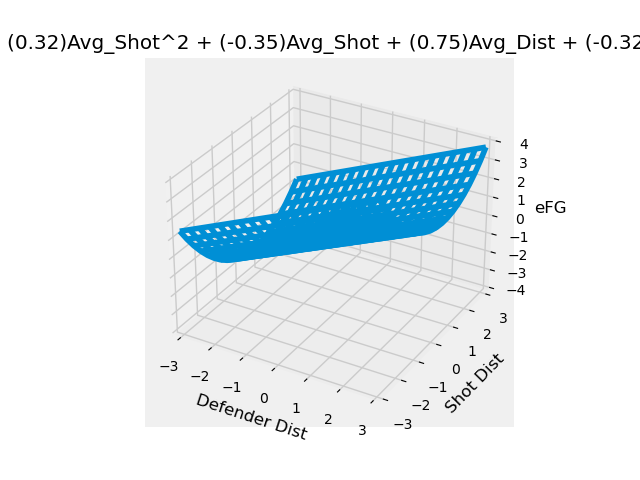

In [9]:
# Create plot of more complicated model
num_points = 20
# plot title
intercept, dist, shot_power, shot = model_.params[:]
plot_title = f"({np.round(shot_power,2)})Avg_Shot^2 + ({np.round(shot,2)})Avg_Shot + ({np.round(dist,2)})Avg_Dist + ({np.round(intercept,2)})"

#use meshgrid to creat the x and y points used in surface
x1,x2 = np.meshgrid(np.linspace(-3,3,num_points),np.linspace(-3,3,num_points))
x1 = x1.reshape(-1,)
x2 = x2.reshape(-1,)
df_plots = pd.DataFrame.from_dict({'Avg_Dist':x1, 'Avg_Shot':x2})
#model surface
Z = model_.predict(df_plots)
x1 = x1.reshape(num_points, num_points)
x2 = x2.reshape(num_points, num_points)
Z  = Z.values.reshape(num_points, num_points)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(x1,x2,Z)
ax.set(xlabel='Defender Dist', 
       ylabel='Shot Dist', 
       zlabel='eFG',
       xlim = [-3.1, 3.1],
       ylim = [-3.1, 3.1],
       zlim = [-4, 4],
       xticks = [-3,-2, -1, 0, 1, 2, 3],
       yticks = [-3,-2, -1, 0, 1, 2, 3],
       zticks = [-4, -3, -2, -1, 0, 1, 2, 3, 4],
       title=plot_title) 
plt.rcParams['figure.figsize'] = [8, 8]
plt.show()

This model suggests that a players effective field goal percentage increases as the player gets further from their defender. Effective field goal percentage weight field goal percentage by point value. The model suggests that a players effective field goal percentage will be optimized if they attempt scoring outside of the middle distances.

Figures below show effective field goal percentage as a function of average defender distance. There is a nonlinear relationship between defender distance and effective field goal percentage. There are situations when being really close to the defender is beneficial to scoring. This happens in the paint where players sometimes depend on making contact with their defender to help them score. 


<IPython.core.display.Javascript object>


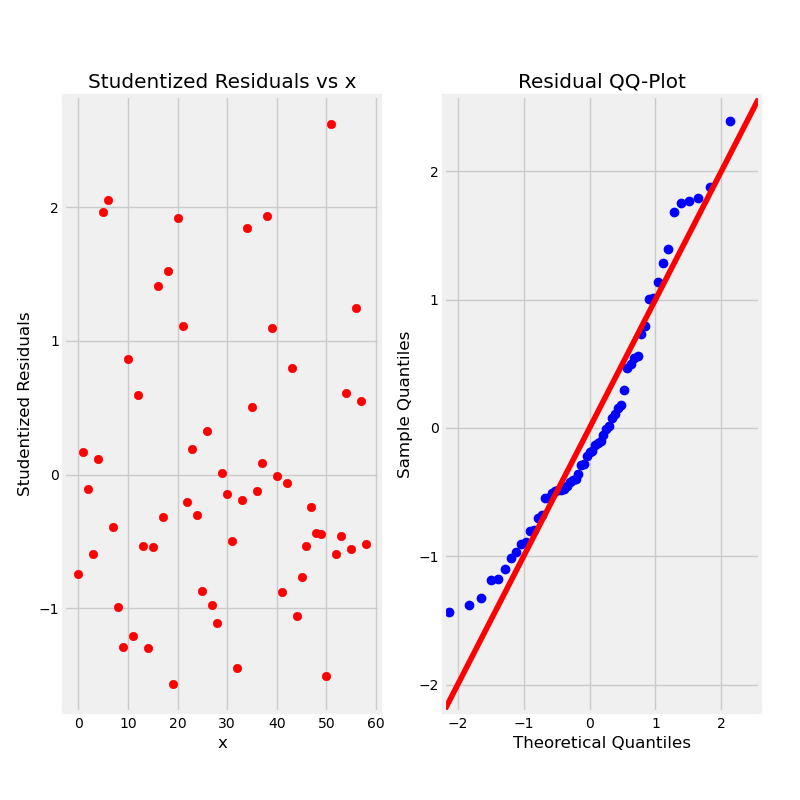

C:\Users\charl\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In [10]:
# create plots
lm_diagnostics(lm2)


<IPython.core.display.Javascript object>


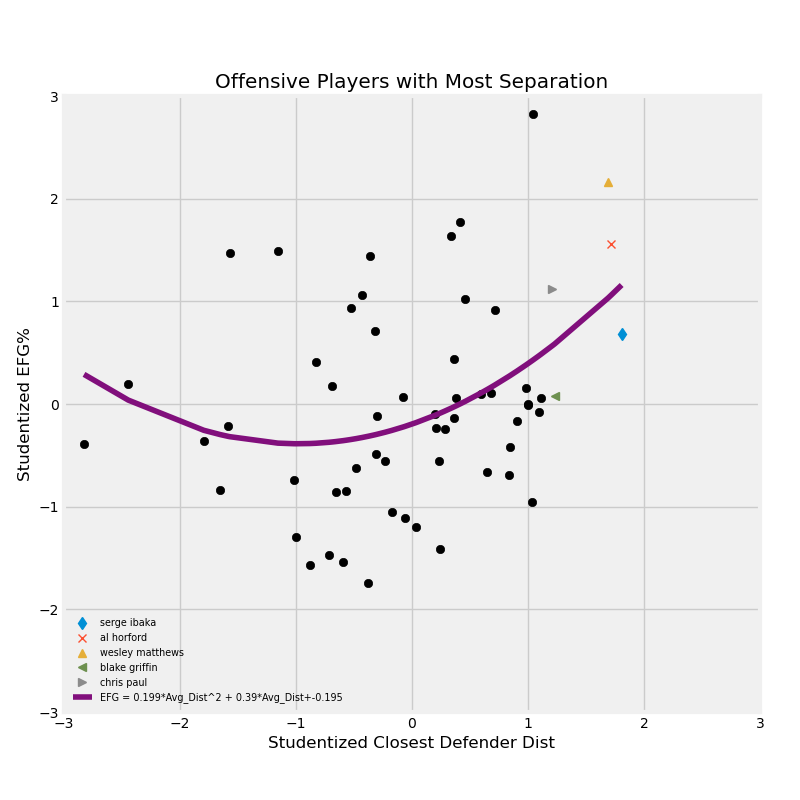

In [11]:
lm_plot_rankx(lm2, studentized_EFG, 'Avg_Dist', 'EFG', False,\
              'Offensive Players with Most Separation',\
              'Studentized Closest Defender Dist', 'Studentized EFG%','best_space_offense.jpg')

<IPython.core.display.Javascript object>


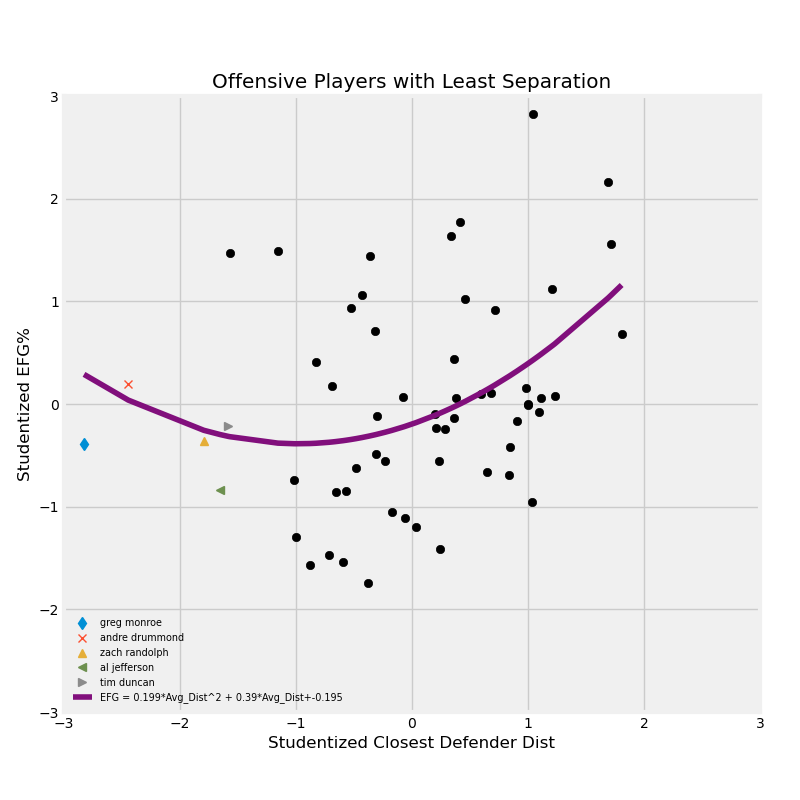

In [12]:
lm_plot_rankx(lm2, studentized_EFG, 'Avg_Dist', 'EFG', True,\
              'Offensive Players with Least Separation',\
              'Studentized Closest Defender Dist', 'Studentized EFG%','worst_space_offense.jpg')

<IPython.core.display.Javascript object>


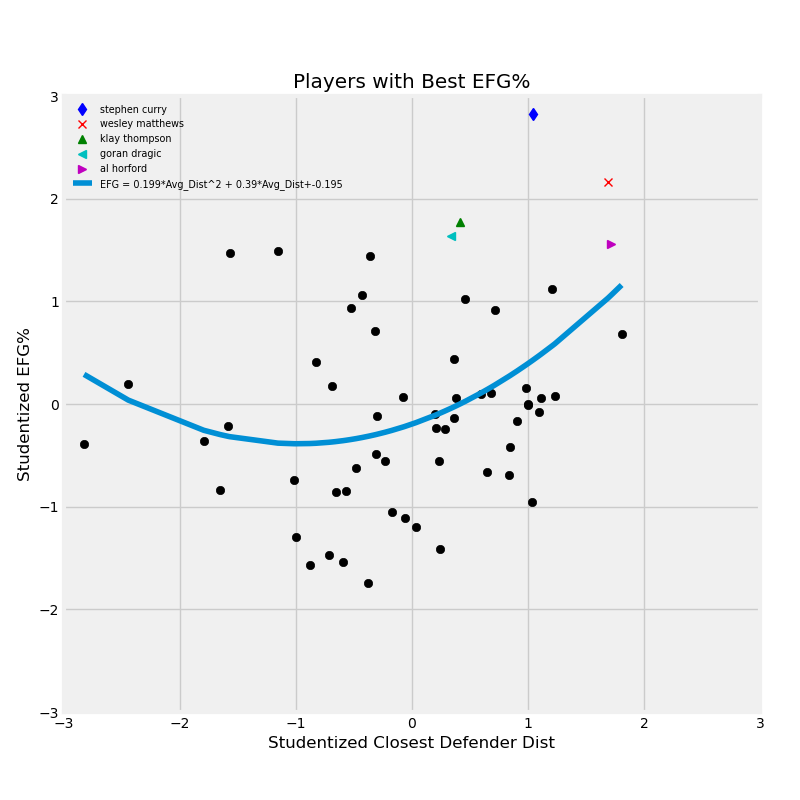

In [13]:
lm_plot_ranky(lm2, studentized_EFG, 'Avg_Dist', 'EFG', False,\
              'Players with Best EFG%','Studentized Closest Defender Dist',\
              'Studentized EFG%','best_EFG_offense.jpg')

<IPython.core.display.Javascript object>


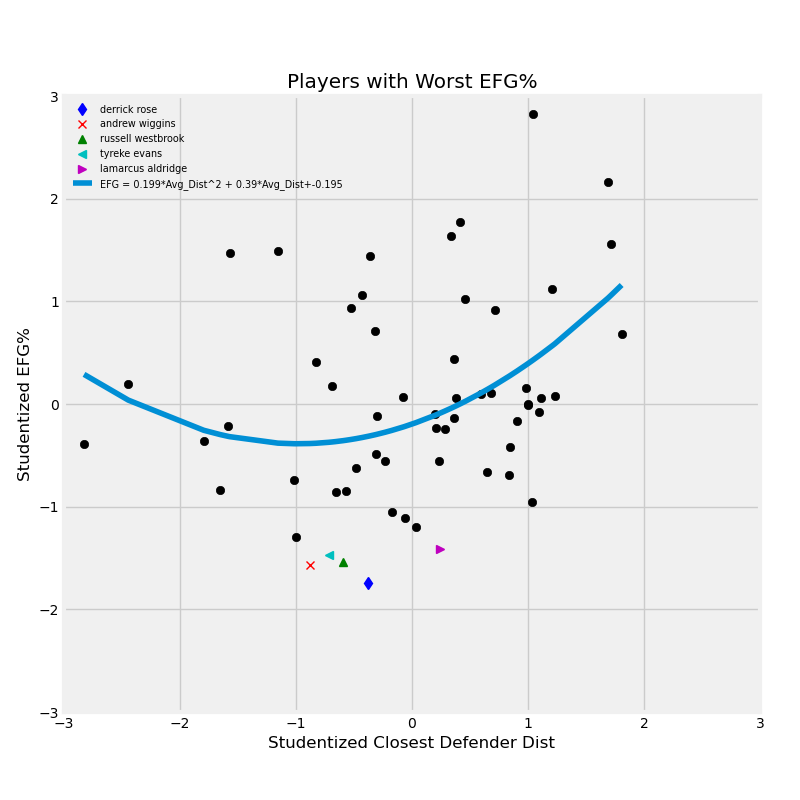

In [14]:
lm_plot_ranky(lm2, studentized_EFG, 'Avg_Dist', 'EFG', True,\
              'Players with Worst EFG%','Studentized Closest Defender Dist',\
              'Studentized EFG%','worst_EFG_offense.jpg')

## Defense

To evaluate defensive performace, we calculate the effective field goal percentage of the offensive players guarded by a particular defensive player. We limit our analysis to players that were listed as the closest defender more than 450 times. This creates a list of 104 players. Our model and plots suggest that, on average, being closer helps on defense. The most effective defenders all stayed closer than average. While being close on defense doesn't guarantee a defensive player will be successful, this is a good strategy. There are many other factors we don't have access to like defender height, jumping ability, and quickness.

In [15]:
## Get the players responsible for the most 'constest' (Roughly top 100)
Defense = X.groupby('CLOSEST_DEFENDER').CLOSEST_DEFENDER_PLAYER_ID.agg(CONTESTS = 'count').sort_values(by='CONTESTS',ascending=False)

Defense.index = fix_names([x.casefold() for x in Defense.index])
valid_players = Defense[Defense.CONTESTS>=450].index

In [16]:
# Determine the Effective Field Goal percentage of players being defended by pooling the makes 
# and misses of the players who were defended by a particular defender. For example
# player A is closest defender to player B for 5 shots: 2 pts: 1/5, 3 pts: 0/0 
# player A is also the closest defender to player C for 5 shots: 2 pts 0/3, 3pts: 2/2
# player A forced a Effective Field Goal percentage of 40%

# Calculate lumped EFG percentage of players attempting field goals closest to person here
FG = X.groupby('CLOSEST_DEFENDER')['FGM'].agg(FG='mean')
EFG = X.groupby('CLOSEST_DEFENDER')['PTS'].agg(EFG = lambda x: np.mean(x==3))
EFG.EFG = 0.5*EFG.EFG+FG.FG

# Calculate average distance away from person attempting the shot
Avg_Dist = X.groupby('CLOSEST_DEFENDER').CLOSE_DEF_DIST.agg(Avg_Dist='mean')
EFG = EFG.join(Avg_Dist)

# Average of how far away from basket shots were taken
Shot_Dist = X.groupby('CLOSEST_DEFENDER').SHOT_DIST.agg(Avg_Shot = 'mean')
EFG = EFG.join(Shot_Dist)

# only get data from players who showed up as closest defender often enough
# to bring down the sample to about 100 players
# Put defender names in firstname lastname format 
EFG = EFG.reset_index().rename(columns={'CLOSEST_DEFENDER':'player_name'})
EFG.player_name = [x.casefold() for x in EFG.player_name.values]
EFG.player_name = fix_names(EFG.player_name.values)

EFG = EFG.set_index('player_name')
EFG = EFG.loc[valid_players]
# standardize df by centering and scaling by std
studentized_EFG = (EFG-EFG.mean())/EFG.std()


In [17]:
# Show the list of players 
print(f"We consider {len(studentized_EFG.index.tolist())} players on defense.")

We consider 104 players on defense.


In [18]:
# show defenders that stayed closest
studentized_EFG = studentized_EFG.sort_values(by='Avg_Dist',ascending=True)
studentized_EFG.head()

,EFG,Avg_Dist,Avg_Shot
miles plumlee,0.473768,-3.054090,-1.936010
alex len,-1.014055,-1.921495,-1.713449
tyler zeller,-0.889490,-1.862125,-1.561226
pau gasol,-0.617574,-1.777630,-1.640780
ryan anderson,0.783999,-1.691424,-0.801033


In [19]:
# show defenders that were furthest
studentized_EFG = studentized_EFG.sort_values(by='Avg_Dist',ascending=False)
studentized_EFG.head()

,EFG,Avg_Dist,Avg_Shot
dirk nowitzki,2.000700,2.376088,-0.262152
rudy gay,0.082174,2.332533,1.216525
trevor ariza,1.901199,2.320972,1.018290
joe johnson,1.256904,2.202520,1.166929
jarrett jack,0.798681,1.642266,1.339165


In [20]:
# show most effective defenders
studentized_EFG = studentized_EFG.sort_values(by='EFG',ascending=True)
studentized_EFG.head()

,EFG,Avg_Dist,Avg_Shot
rudy gobert,-2.790023,-1.187444,-1.545831
roy hibbert,-2.190419,-1.358703,-1.368371
draymond green,-2.143634,-0.856723,-0.206933
anthony davis,-2.093246,-0.400439,-0.634900
serge ibaka,-1.688111,-0.041311,-0.524918


In [21]:
# show least effective defenders
studentized_EFG = studentized_EFG.sort_values(by='Avg_Dist',ascending=False)
studentized_EFG.head()

,EFG,Avg_Dist,Avg_Shot
dirk nowitzki,2.000700,2.376088,-0.262152
rudy gay,0.082174,2.332533,1.216525
trevor ariza,1.901199,2.320972,1.018290
joe johnson,1.256904,2.202520,1.166929
jarrett jack,0.798681,1.642266,1.339165


In [22]:
#Using forward search yields a model that uses only defender distance
predictors = studentized_EFG.columns.tolist().copy()
predictors.remove('EFG')
response   = 'EFG'

#Fit model and show summary
model_defense = sequential_forward_selection(data = studentized_EFG, predictors = predictors, response = response, max_length = 10, numerical_predictors = predictors, entry_limit = 0.10)
model_defense.summary()

Iteration 1
The new p-value is 2.5571870995004195e-05 and the new rsquared_adj is 0.15195819888587137
Iteration 2
The new p-value is 0.07255083164319327 and the new rsquared_adj is 0.17060209879400867
Iteration 3
The new p-value is 1.0 and the new rsquared_adj is 0.17060209879400867


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EFG   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     11.59
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           2.93e-05
Time:                        10:01:49   Log-Likelihood:                -136.32
No. Observations:                 104   AIC:                             278.6
Df Residuals:                     101   BIC:                             286.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1099      0.108     -1.019      0.311      -0.324       0.104
Avg_Dist                  0.3974      0.090      4.428      0.000       0.219       0.575
np.power(Avg_Dist, 2)     0.1110      0.061      1.815      0.073      -0.010       0.232
==============================================================================
Omnibus:                        0.215   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.389
Skew:                          -0.059   Prob(JB):                        0.823
Kurtosis:                       2.725   Cond. No.                         2.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>


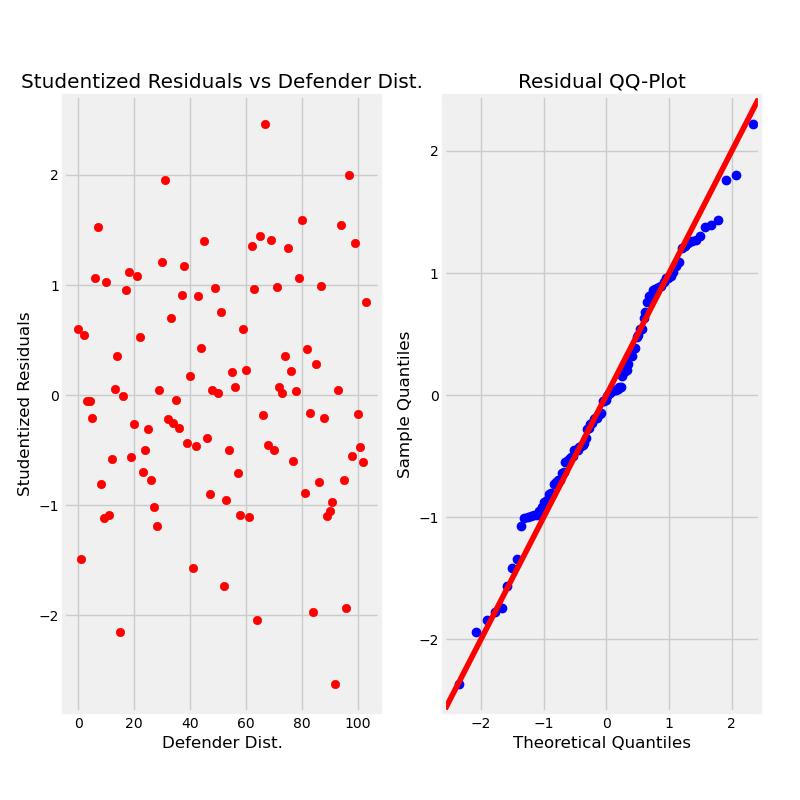

C:\Users\charl\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In [23]:
# Plot residuals and assess Normality
lm_diagnostics(model_defense,"Defender Dist.")

<IPython.core.display.Javascript object>


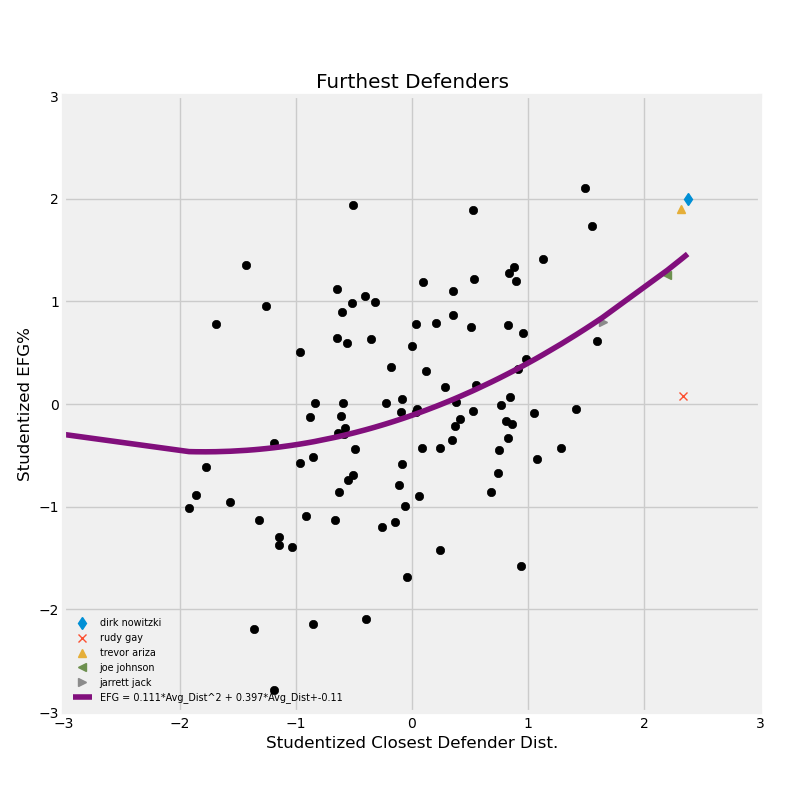

In [24]:
lm_plot_rankx(model_defense, studentized_EFG, 'Avg_Dist', 'EFG', False,\
              'Furthest Defenders', 'Studentized Closest Defender Dist.',\
              'Studentized EFG%','worst_space_defense.png')

<IPython.core.display.Javascript object>


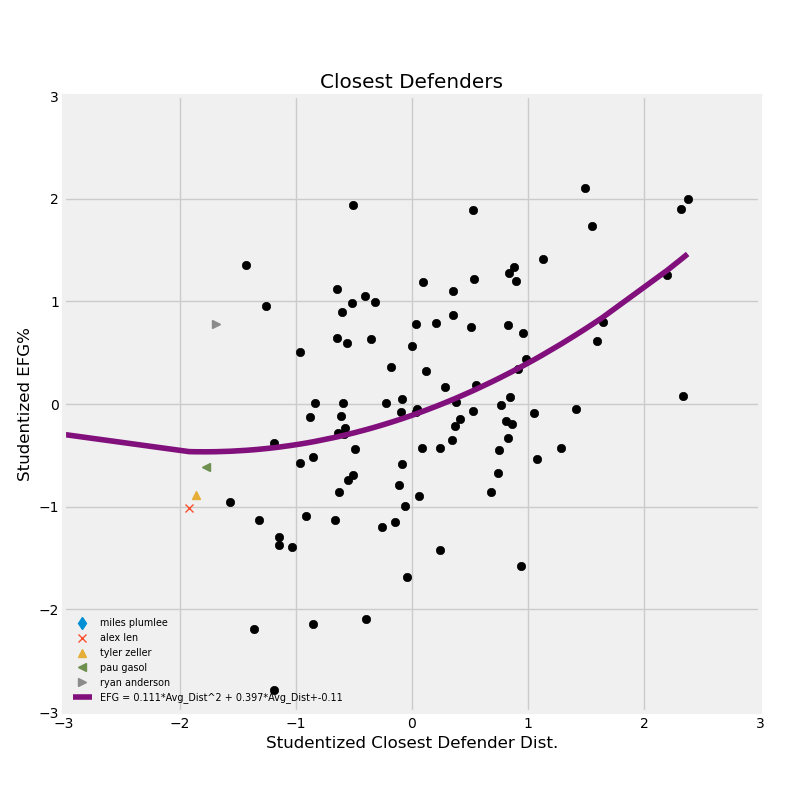

In [25]:
lm_plot_rankx(model_defense, studentized_EFG, 'Avg_Dist', 'EFG', True,\
              'Closest Defenders', 'Studentized Closest Defender Dist.','Studentized EFG%',\
              'best_space_defense.png')

As shown above, the closest defenders are all power forwards and centers, usually tasked with defending the basket. The furthest defenders are a mixture of all positions. 

<IPython.core.display.Javascript object>


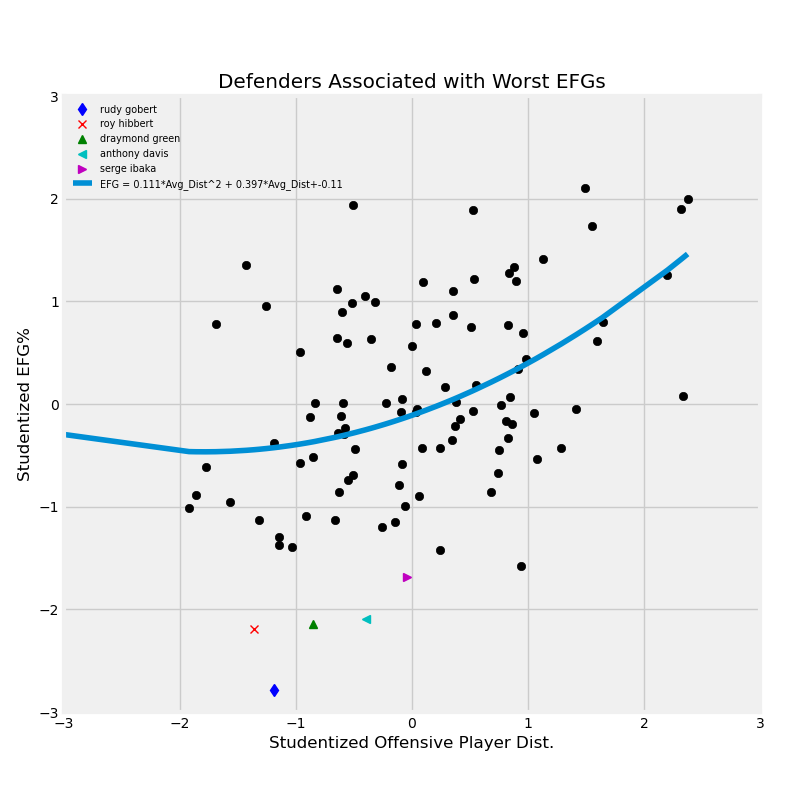

In [26]:
lm_plot_ranky(model_defense, studentized_EFG, 'Avg_Dist', 'EFG',True,\
              'Defenders Associated with Worst EFGs', 'Studentized Offensive Player Dist.', 'Studentized EFG%',\
              'best_defense_efg.png')

<IPython.core.display.Javascript object>


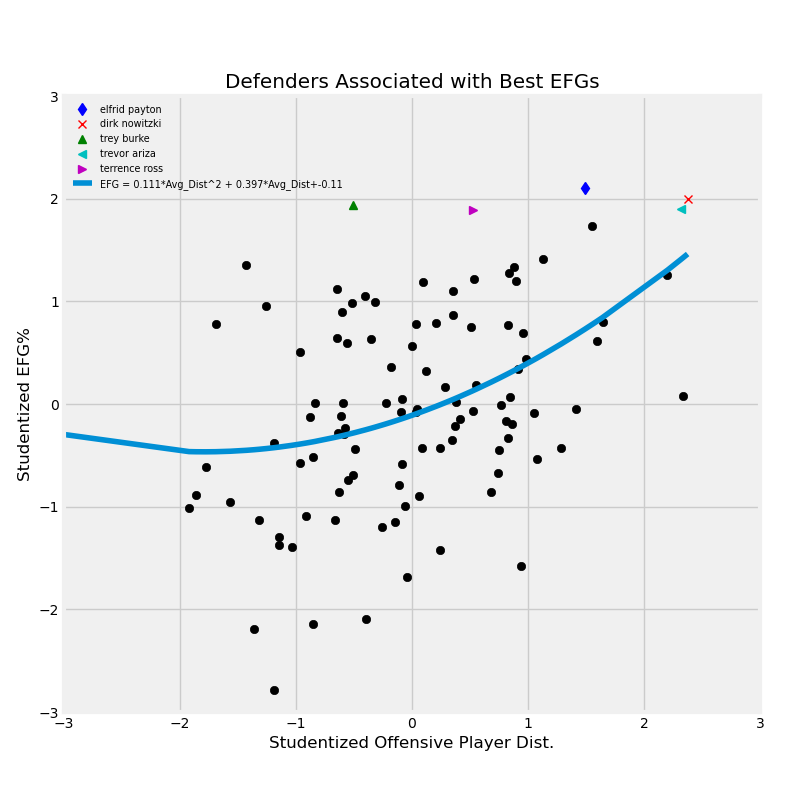

In [27]:
lm_plot_ranky(model_defense, studentized_EFG, 'Avg_Dist', 'EFG',False,\
              'Defenders Associated with Best EFGs', 'Studentized Offensive Player Dist.', 'Studentized EFG%',\
              'worst_defense_efg.png')   